<a href="https://colab.research.google.com/github/PDNALab/AlphaFolding/blob/main/alphafolding.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="width:120px;">
</a>

## Protein Folding with AlphaFold2 Using a Single Sequence

#### This notebook includes the following features:

- Running iterative predictions with AlphaFold2 (monomer models 1 and 2) based on a query sequence.

- Visualizing the predicted protein structures.

- For predictions that successfully reach the native state, earlier predictions along the way may potentially resemble protein folding intermediates (if you found experiments that aligned well with our computational method for folding intermediates identification, let us know!).

- Downloading and visualizing previously generated structure predictions presented in [this study](https://www.biorxiv.org/content/10.1101/2024.08.25.609581v1).

#### Reproduction instructions of [this study](https://www.biorxiv.org/content/10.1101/2024.08.25.609581v1):

- We performed iterative structure predictions from a single sequence. The first step is a basic single sequence based structure prediction using AlphaFold2 without sequence alignments. Then the structure prediction served as template for the next iteration of prediction with original sequence. The main parameters for each iteration are:

  (1) model type, there are two AlphaFold2-ptm models can take template structures as input for prediction - model 1 and 2;

  (2) number of recyclings, we recommend trying increasing number of recyclings. The structure prediction iteration that finds the native state with the least number of recycling has more intermediate steps. They might resemble actual folding intermediates;
  
  (3) sequence separation mask, defines which pairwise residue distograms are used for next prediction iteration, e.g. all distance information will be used if sequence separation mask is 0;
  
  (4) the mode of how distograms are used for next prediction iteration, we use `dgram_retrain`, which replaces distogram head of AlphaFold2 with the one retrained to map output bins to template bins, without distogram noise.

  For results in figures 2 and 6, the model type, sequence separation mask, and number of recycles are in the following table. For results in figure 4, we performed iterative structure predictions using both model types, sequence separation mask 0, and number of recyclings 0, 1, 3, 5, 8. Their predictions can be downloaded and visualized in this notebook.

| Protein | Model type   | sequence separation mask | number of recyclings |
  |---------|--------------|--------------------------|-----------------|
  | 3gb1    | model_1_ptm  | 0                        | 2               |
  | 1mi0    | model_1_ptm  | 0                        | 1               |
  | 1hz5    | model_1_ptm  | 0                        | 0               |
  | 1kh0    | model_2_ptm  | 0                        | 0               |
  | 1ubq    | model_1_ptm  | 0                        | 2               |
  | 2hda    | model_1_ptm  | 0                        | 2               |
  | 1fnf    | model_2_ptm  | 0                        | 1               |

  



In [1]:
#@title set up environment and load utility functions {"vertical-output":true,"form-width":"50%","display-mode":"form"}
# Standard library imports
import argparse
import glob
import json
import os, re
import pickle
import shutil
import sys
import threading
import warnings
import zipfile
import requests

if not os.path.isdir("params"):
  # get code
  os.system("pip -q install git+https://github.com/ccccclw/ColabDesign.git")
  # for debugging
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  # download params
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")

# Install third-party libraries
!pip install plotly
!pip install mdtraj

# Third-Party library imports
import jax
import jax.numpy as jnp
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from tqdm.notebook import tqdm
from google.colab import files
from IPython.display import HTML
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import mdtraj as md
from concurrent.futures import ThreadPoolExecutor, as_completed

# Bioinformatics imports
from Bio.PDB import *

# Colabdesign imports
from colabdesign import af, clear_mem, mk_afdesign_model
from colabdesign.mpnn import mk_mpnn_model
from colabdesign.af.alphafold.common import residue_constants
from colabdesign.shared.plot import make_animation, plot_pseudo_3D, show_pdb
from colabdesign.shared.protein import _np_get_cb

# Set default renderer for plotly
pio.renderers.default = 'colab'
# Suppress futureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

#utility functions
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"


def get_dgram(positions, num_bins=39, min_bin=3.25, max_bin=50.75):
  atom_idx = residue_constants.atom_order
  atoms = {k:positions[...,atom_idx[k],:] for k in ["N","CA","C"]}
  cb = _np_get_cb(**atoms, use_jax=False)
  dist2 = np.square(cb[None,:] - cb[:,None]).sum(-1,keepdims=True)
  lower_breaks = np.linspace(min_bin, max_bin, num_bins)
  lower_breaks = np.square(lower_breaks)
  upper_breaks = np.concatenate([lower_breaks[1:],np.array([1e8], dtype=jnp.float32)], axis=-1)
  return ((dist2 > lower_breaks) * (dist2 < upper_breaks)).astype(float)

def sample_gumbel(shape, eps=1e-10):
  """Sample from Gumbel(0, 1)"""
  U = np.random.uniform(size=shape)
  return -np.log(-np.log(U + eps) + eps)

def sample_uniform(shape, eps=1e-10):
  """Sample from Uniform(0, 1)"""
  U = np.random.uniform(size=shape)
  return U + eps

def xyz_atom37(pdb_file):
  """
  Convert atom coordinates [num_atom, 3] from xyz read from file such as pdb to atom37 format.
  """
  atom37_order = residue_constants.atom_order
  parser = PDBParser()
  structure = parser.get_structure("A", pdb_file)
  atoms = list(structure.get_atoms())
  length = len(list(structure.get_residues()))
  atom37_coord = np.zeros((length, 37, 3))

  for atom in atoms:
    atom37_index = atom37_order[atom.get_name()]
    residue_index = atom.get_parent().id[1]
    atom37_coord[residue_index-1][atom37_index] = atom.get_coord()
  return atom37_coord

def sequence_to_one_hot(sequence):
    """
    Convert a sequence string into a one-hot encoding matrix of shape (N, 20),
    where N is the number of residues, and 20 is the number of amino acids.

    Parameters:
    - sequence: str, the input sequence of amino acids (e.g., "ACDE").

    Returns:
    - one_hot_matrix: np.ndarray, one-hot encoding matrix of shape (N, 20).
    """
    # Convert the sequence to a list of integers using aa_order dictionary
    aa_dict = residue_constants.restype_order
    seq_indices = [aa_dict.get(aa, -1) for aa in sequence]  # -1 for unknown AA

    # Ensure no unknown amino acids (-1) are present in the sequence
    if any(idx == -1 for idx in seq_indices):
        raise ValueError("Sequence contains invalid amino acid(s) not present in aa_order.")

    # Create a one-hot encoding matrix
    N = len(sequence)
    one_hot_matrix = np.eye(20)[seq_indices]

    return one_hot_matrix


   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   - -------------------------------------- 0.8/19.1 MB 8.5 MB/s eta 0:00:03
   --- ------------------------------------ 1.6/19.1 MB 4.2 MB/s eta 0:00:05
   ----- ---------------------------------- 2.6/19.1 MB 4.4 MB/s eta 0:00:04
   --------- ------------------------------ 4.5/19.1 MB 6.2 MB/s eta 0:00:03
   ------------ --------------------------- 5.8/19.1 MB 6.2 MB/s eta 0:00:03
   -------------- ------------------------- 7.1/19.1 MB 6.2 MB/s eta 0:00:02
   ------------------ --------------------- 8.9/19.1 MB 6.5 MB/s eta 0:00:02
   -------------------- ------------------- 10.0/19.1 MB 6.2 MB/s eta 0:00:02
   ----------------------- ---------------- 11.3/19.1 MB 6.2 MB/s eta 0:00:02
   ---------------------------- ----------- 13.4/19.1 MB 6.7 MB/s eta 0:00:01
   ------------------------------ --------- 14.7/19.1 MB 6.8 MB/s eta 0:00:01
   --------------------------------- ------ 16.0/19.1 MB 6.6 MB/s eta 0:00:01
 

ModuleNotFoundError: No module named 'jax'

In [ ]:
#@title Iterative protein structure predictions - input preparation {"vertical-output":true,"form-width":"50%","display-mode":"form"}
#@markdown  - the default sequence is 3GB1. If you would like to start the prediction from a template structure, upload via custom option in `template`.



starting_seq = "MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE" #@param {type:"string"}
starting_seq = re.sub("[^A-Z]", "", starting_seq.upper())
##default sequence is PDB:3GB1 if no sequence is provided
starting_seq = "MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE" if len(starting_seq) == 0 else starting_seq
length = len(starting_seq)
template = "None" #@param ["custom","None"]
if template == "custom":
  custom_template_path = os.path.join(template,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
  template_path = os.path.join(custom_template_path,fn)


In [ ]:
#@title Iterative protein structure predictions - initialize the model with parameters and run {"vertical-output":true,"form-width":"50%","display-mode":"form"}
clear_mem()
model_name = "model_1_ptm" #@param ["model_1_ptm", "model_2_ptm","both"]
use_multimer = False
model_name = None if model_name == "both" else [model_name]
af_model = mk_afdesign_model(protocol="hallucination",
                             use_templates=True,
                             debug=True,
                             model_names=model_name,
                             use_multimer=use_multimer)
af_model.prep_inputs(length=length)

mode = "dgram" #@param ["dgram","dgram_retrain"]
if "dgram" in mode:
  if "retrain" in mode and not use_multimer:
    # update distogram head to return all 39 bins
    af_model._cfg.model.heads.distogram.first_break = 3.25
    af_model._cfg.model.heads.distogram.last_break = 50.75
    af_model._cfg.model.heads.distogram.num_bins = 39
    af_model._model = af_model._get_model(af_model._cfg)
    from colabdesign.af.weights import __file__ as af_path
    template_dgram_head = np.load(os.path.join(os.path.dirname(af_path),'template_dgram_head.npy'))
    for k in range(len(af_model._model_params)):
      params = {"weights":jnp.array(template_dgram_head[k]),"bias":jnp.zeros(39)}
      af_model._model_params[k]["alphafold/alphafold_iteration/distogram_head/half_logits"] = params
  else:
    dgram_map = np.eye(39)[np.repeat(np.append(0,np.arange(15)),4)]
    dgram_map[-1,:] = 0

iterations = 50 #@param [50, 100, 200] {type:"raw"}
use_dgram_noise = None #@param ["g","u","None"]
use_dropout = False #@param {type:"boolean"}
seqsep_mask =  0 #@param {type:"integer"}
num_recycles = 2 #@param {type:"integer"}

sample_models = True if model_name == "both" else False
dgram_noise_type = use_dgram_noise
use_dgram_noise = False if use_dgram_noise is None else True

L = sum(af_model._lengths)
af_model.restart(mode="gumbel")
af_model._inputs["rm_template_seq"] = False
# gather info about inputs
if "offset" in af_model._inputs:
  offset = af_model._inputs
else:
  idx = af_model._inputs["residue_index"]
  offset = idx[:,None] - idx[None,:]

# initialize sequence
if len(starting_seq) > 1:
  af_model.set_seq(seq=starting_seq)
af_model._inputs["bias"] = np.zeros((L,20))

# initialize coordinates/dgram
af_model._inputs["batch"] = {"aatype":np.zeros(L).astype(int),
                             "all_atom_mask":np.zeros((L,37)),
                             "all_atom_positions":np.zeros((L,37,3)),
                             "dgram":np.zeros((L,L,39))}

if template == "custom":
  xyz = xyz_atom37(pdb_file=template_path)
  af_model._inputs["batch"]["all_atom_positions"] = xyz
  dgram = get_dgram(xyz)
  mask = np.abs(offset) > seqsep_mask
  af_model._inputs["batch"]["dgram"] = dgram * mask[:,:,None]
  if use_dgram_noise:
    if dgram_noise_type == "g":
      noise = sample_gumbel(dgram.shape) * (1 - k/iterations)
      dgram = softmax(np.log(dgram + 1e-8) + noise, -1)
    elif dgram_noise_type == 'u':
      noise = sample_uniform(dgram.shape) * (1 - k/iterations)
      dgram = softmax(np.log(dgram + 1e-8) + noise, -1)
plddts = []
print(f"running seq {starting_seq} with model: {'both' if model_name is None else model_name} for {iterations} steps")
for k in range(iterations):
  # noise
  if k > 0:
    dgram_xyz = get_dgram(xyz)
    dgram_prob = softmax(dgram_logits,-1)

    if mode == "xyz":
      dgram = dgram_xyz
    if mode == "dgram":
      dgram = dgram_prob @ dgram_map
      dgram[...,14:] = dgram_xyz[...,14:] * dgram_prob[...,-1:]
    if mode == "dgram_retrain":
      dgram = dgram_prob

    if use_dgram_noise:
      if dgram_noise_type == "g":
        noise = sample_gumbel(dgram.shape) * (1 - k/iterations)
        dgram = softmax(np.log(dgram + 1e-8) + noise, -1)
      elif dgram_noise_type == 'u':
        noise = sample_uniform(dgram.shape) * (1 - k/iterations)
        dgram = softmax(np.log(dgram + 1e-8) + noise, -1)

    # add mask to avoid local contacts being fixed (otherwise there is a bias toward helix)
    mask = np.abs(offset) > seqsep_mask
    af_model._inputs["batch"]["dgram"] = dgram * mask[:,:,None]

  # prediction
  aux = af_model.predict(return_aux=True, verbose=False,
                        sample_models=sample_models,
                        dropout=use_dropout, num_recycles=num_recycles)
  plddt = aux["plddt"]
  plddts.append(np.average(plddt))
  seq = aux["seq"]["hard"][0].argmax(-1)
  xyz = aux["atom_positions"].copy()
  dgram_logits = aux["debug"]["outputs"]["distogram"]["logits"]

  # update inputs
  af_model._inputs["batch"]["aatype"] = seq
  af_model._inputs["batch"]["all_atom_mask"][:,:4] = np.sqrt(plddt)[:,None]
  af_model._inputs["batch"]["all_atom_positions"] = xyz

  # save results
  af_model._save_results(aux)
  af_model._k += 1
  af_model.save_pdb(f"iter_{k}.pdb")

running seq MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE with model: ['model_1_ptm'] for 50 steps
1 models [0] recycles 2 hard 1 soft 0 temp 1 loss 3.11 con 3.11 plddt 0.59 ptm 0.42
2 models [0] recycles 2 hard 1 soft 0 temp 1 loss 2.74 con 2.74 plddt 0.72 ptm 0.50
3 models [0] recycles 2 hard 1 soft 0 temp 1 loss 2.19 con 2.19 plddt 0.85 ptm 0.63
4 models [0] recycles 2 hard 1 soft 0 temp 1 loss 2.10 con 2.10 plddt 0.86 ptm 0.65
5 models [0] recycles 2 hard 1 soft 0 temp 1 loss 1.85 con 1.85 plddt 0.92 ptm 0.71
6 models [0] recycles 2 hard 1 soft 0 temp 1 loss 1.84 con 1.84 plddt 0.92 ptm 0.72
7 models [0] recycles 2 hard 1 soft 0 temp 1 loss 1.84 con 1.84 plddt 0.93 ptm 0.72
8 models [0] recycles 2 hard 1 soft 0 temp 1 loss 1.84 con 1.84 plddt 0.93 ptm 0.72
9 models [0] recycles 2 hard 1 soft 0 temp 1 loss 1.84 con 1.84 plddt 0.93 ptm 0.72
10 models [0] recycles 2 hard 1 soft 0 temp 1 loss 1.83 con 1.83 plddt 0.93 ptm 0.72
11 models [0] recycles 2 hard 1 soft 0 temp 1 los

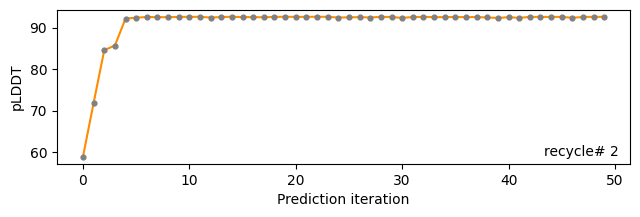

In [ ]:
#@title Iterative protein structure predictions - visualization {"vertical-output":true,"form-width":"50%","display-mode":"form"}
#@markdown - visualize conformational changes and average pLDDT scores
fig, ax=plt.subplots(1,1,figsize=(7.4,2))
ax.scatter(range(len(plddts)),np.array(plddts)*100,s=12, color='grey', zorder=1)
ax.plot(np.array(plddts)*100,'darkorange',zorder=0)
ax.set_xlabel("Prediction iteration")
ax.set_ylabel("pLDDT")
ax.text(ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.85,\
        ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.05,f"recycle# {num_recycles}")
HTML(af_model.animate(dpi=80, interval=300))

In [ ]:
#@title Visualize previously generated iterative structure predictions - load functions for downloading data from zenodo and visulization {"vertical-output":true,"form-width":"50%","display-mode":"form"}
download_embedding_data = True #@param {type:"boolean"}

def plot_embedding(embedding,ss,rmsd,pdb_id,rmsd_cutoff=1,selection=None,selection_min=0, selection_max=1):
    fig = go.Figure()
    # plt.figure(figsize=(20,20))
    embedding_df = pd.DataFrame()
    embedding_df['dim1'] = np.round(embedding[:, 0],2)
    embedding_df['dim2'] = np.round(embedding[:, 1],2)
    embedding_df['%alpha'] = np.round(ss[:,3],2)
    embedding_df['%beta'] = np.round(ss[:,2],2)
    embedding_df['%coil'] = np.round(ss[:,4],2)
    embedding_df['RMSD'] = np.round(rmsd,2)*10
    embedding_df['pdb_id'] = np.array([i[-5:-1].upper() for i in pdb_id])
    if selection:
        for key in embedding_df.keys():
            embedding_df[key] = embedding_df[key][np.where((embedding_df[selection]>selection_min) & (embedding_df[selection]<selection_max))[0]]
    fig = px.scatter(embedding_df,x='dim1',y='dim2',color='RMSD',
                     custom_data=[embedding_df['pdb_id'],
                                 embedding_df['%alpha'],
                                 embedding_df['%beta'],
                                 embedding_df['%coil'],
                                 embedding_df['RMSD']],
                     hover_data={'dim1':False,
                                 'dim2':False,
                                 'pdb_id':True,
                                 '%alpha': True,
                                 '%beta': True,
                                 '%coil': True,
                                 'RMSD': (':.2f')},
                    color_continuous_scale='RdBu_r')
    fig.update_layout(
    #     margin=dict(l=10, r=10, t=10, b=10),
        width=660,height=660,
    #     paper_bgcolor="LightSteelBlue",
    )
    fig.update_traces(marker=dict(size=10,
                                  line=dict(width=2,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    # Add dropdown
    fig.update_xaxes(showspikes=True,spikecolor="black", spikesnap="cursor", spikemode="across")
    fig.update_yaxes(showspikes=True,spikecolor="black", spikesnap="cursor", spikemode="across")
    fig.update_layout(
    #     xaxis=dict(rangeslider=dict(visible=True)),
        updatemenus=[go.layout.Updatemenu(
                active=0,
                buttons=list([
                    dict(
                        args=[{"marker.color": [embedding_df["RMSD"]], "coloraxis.colorbar.title":"RMSD"}],
                        label="RMSD",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.color": [embedding_df["%alpha"]], "coloraxis.colorbar.title":"%alpha"}],
                        label="helix percentage",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.color": [embedding_df["%beta"]], "coloraxis.colorbar.title":"%beta"}],
                        label="beta percentage",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.color": [embedding_df["%coil"]], "coloraxis.colorbar.title":"%coil"}],
                        label="coil percentage",
                        method="restyle"
                    )
                ]),
                direction="down",
                pad={"l": -30, "t": 1},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )
    fig.update_traces(hovertemplate="PDB: %{customdata[0]}<br> \u03B1: %{customdata[1]}; \u03B2: %{customdata[2]}; C: %{customdata[3]}<br> RMSD: %{customdata[4]:.2f} ") #
    fig.show("colab")

# Function to download part of a file in small chunks
def download_chunk(file_url, start, end, file_name, pbar, chunk_size=1024*1024):
    headers = {'Range': f'bytes={start}-{end}'}
    response = requests.get(file_url, headers=headers, stream=True)

    with open(file_name, 'r+b') as file:
        file.seek(start)

        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:  # Filter out keep-alive new chunks
                file.write(chunk)
                pbar.update(len(chunk))

# Function to download a file using multiple threads, each handling a part of the file
def download_large_file_multithreaded(url, destination, num_threads=4, chunk_size=1024*1024):
    # Get the total file size
    response = requests.head(url)

    if 'content-length' in response.headers:
        total_size = int(response.headers['content-length'])
    else:
        # Fallback if content-length is not provided
        print("Warning: 'content-length' header is missing. Downloading the file without knowing the size.")
        total_size = None  # Unable to determine the total size
    if total_size is None:
        # Perform a single-threaded download as a fallback
        with requests.get(url, stream=True) as r:
            with open(destination, 'wb') as f:
                for chunk in r.iter_content(chunk_size=chunk_size):
                    if chunk:  # Filter out keep-alive chunks
                        f.write(chunk)
        print(f"Download completed: {destination}")
    else:
        # Create an empty file with the appropriate size
        with open(destination, 'wb') as f:
            f.truncate(total_size)

        # Define the size for each thread to download
        part_size = total_size // num_threads

        # Set up progress bar
        pbar = tqdm(total=total_size, unit='B', position=0, leave=True, unit_scale=True, desc=destination)

        # Create a thread pool for parallel downloads
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = []
            for i in range(num_threads):
                start = i * part_size
                end = (i + 1) * part_size - 1 if i < num_threads - 1 else total_size - 1
                futures.append(executor.submit(download_chunk, url, start, end, destination, pbar, chunk_size))

            # Wait for all threads to finish
            for future in futures:
                future.result()

        pbar.close()

# Function to extract a single file and update progress bar
def extract_file(zip_ref, file_info, destination, progress_bar):
    zip_ref.extract(file_info, destination)
    progress_bar.update(1)  # Update progress bar after extracting each file

# Multi-threaded decompression function with progress bar
def extract_zip_multithreaded(zip_path, destination, file_name=None, num_threads=4):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.infolist()
        if file_name != None:
          filelist = []
          for file in file_list:
            for filename in file_name:
              if filename in file.filename:
                print(file.filename)
                filelist.append(file)
          file_list = filelist

        # Create the destination folder if it doesn't exist
        os.makedirs(destination, exist_ok=True)

        # Initialize tqdm progress bar
        with tqdm(total=len(file_list), position=0, leave=True, desc="Decompressing", unit="file") as progress_bar:
            # Create threads to extract files in parallel
            threads = []
            for i in range(num_threads):
                # Split the file list for each thread
                part_files = file_list[i::num_threads]
                for file_info in part_files:
                    thread = threading.Thread(target=extract_file, args=(zip_ref, file_info, destination, progress_bar))
                    threads.append(thread)
                    thread.start()

            # Wait for all threads to finish
            for thread in threads:
                thread.join()


def download_zenodo(record_id,download_file=None):

    zenodo_url = f'https://zenodo.org/api/records/{record_id}'

    # Get record metadata
    response = requests.get(zenodo_url)
    response.raise_for_status()
    metadata = response.json()

    # Get all file URLs
    files = metadata['files']

    # Create a folder to store downloaded files
    # if os.path.exists('zenodo_downloads'):
    #     shutil.rmtree('zenodo_downloads')
    os.makedirs('zenodo_downloads', exist_ok=True)
    # Download and decompress each file in the record
    for file_info in files:
        file_url = file_info['links']['self']
        file_name = file_info['key']
        if file_name in download_file:
            file_path = os.path.join('zenodo_downloads', file_name)
            print(f'Downloading {file_name} with memory-efficient multi-threading...')
            download_large_file_multithreaded(file_url, file_path, num_threads=4, chunk_size=1024*1024)

            # Check if the file is a ZIP file and decompress it
            if file_name == 'rmsds_plddts_embeddings.zip':
                print(f'Decompressing {file_name}...')
                extract_zip_multithreaded(file_path, 'zenodo_downloads', num_threads=4)

                # with zipfile.ZipFile(file_path, 'r') as zip_ref:
                #     zip_ref.extractall('zenodo_downloads')
                os.remove(file_path)  # Optionally remove the zip file after extraction
            # elif "trajs" in file_path or file_path == '0_0_iter_0_pdb.zip':
            #     extract_zip_multithreaded(file_path, 'zenodo_downloads', file_name=pdb, num_threads=4)


print('Download files useful for both trajectory and embedding visualization.')
record_ids = {'6':'13766276','3':'13766281','4':'13777196','2':'13772757','18_and_embeddings':'13930561','57':'13788039'}
fig_1_6_pdbs = ['3gb1','1mi0','1hz5','1kh0','1ubq','2hda','1fnf']
download_file = ['rmsds_plddts_embeddings.zip','model_1_2_gap_0_6_per_residue_plddts.zip','0_0_iter_0_pdb.zip']
record_id = record_ids['18_and_embeddings']
#download statistics, t-SNE embeddings
if download_embedding_data:
  if not os.path.exists('zenodo_downloads/rmsds_plddts_embeddings/'):
    download_zenodo(record_id=record_id,download_file=download_file)
    print('Download and decompression complete.')



Download files useful for both trajectory and embedding visualization.


In [ ]:
#@title Visualize previously generated iterative structure predictions - interative visualization of large scale predictions  {"vertical-output":true,"form-width":"50%","display-mode":"form"}
#@markdown - interative visulization of Figure 5 in [this study](https://www.biorxiv.org/content/10.1101/2024.08.25.609581v1). It supports subset visualization based on sequence length and rmsd range. You can change the colorbar to represent different type of measure, default is the lowest RMSD in iterative structure predictions from multiple run options. You can see a summary after hovering over each point. (If the plot didn't show up, you can try running this cell again.)

visualize_embeddings = True #@param {type:"boolean"}
seq_length_min = 0 #@param {type:"integer"}
seq_length_max = 100 #@param {type:"integer"}
best_rmsd_min = 0 #@param {type:"integer"}
best_rmsd_max = 3 #@param {type:"integer"}

if visualize_embeddings:
    if 'all_ss_gap0.npy' not in os.listdir('zenodo_downloads'):
        download_file = ['all_ss_gap0.npy','all_ss_gap6.npy',
                         'all_pdbs_gap0.npy','all_seq_length_gap0.npy',
                         'all_rmsd_model1_gap0.npy','all_rmsd_model2_gap0.npy']
        record_id = record_ids['18_and_embeddings']
        download_zenodo(record_id=record_id,download_file=download_file)

all_ss = np.load("./zenodo_downloads/all_ss_gap0.npy")
all_rmsd = np.load("./zenodo_downloads/all_rmsd_model1_gap0.npy")
all_rmsd2 = np.load("./zenodo_downloads/all_rmsd_model2_gap0.npy")
all_seq_length = np.load("./zenodo_downloads/all_seq_length_gap0.npy")
all_rmsd = np.array(all_rmsd)
all_rmsd2 = np.array(all_rmsd2)
all_tmfile_pd=np.load("./zenodo_downloads/all_pdbs_gap0.npy")
all_EH = np.array([[(np.array([*i])=='E').sum()/((np.array([*i])=='E').sum()+(np.array([*i])=='H').sum()),
                    (np.array([*i])=='H').sum()/((np.array([*i])=='E').sum()+(np.array([*i])=='H').sum()),
                    (np.array([*i])=='E').sum()/len(i),
                    (np.array([*i])=='H').sum()/len(i),
                    (np.array([*(i.strip('C'))])=='C').sum()/len(i)] for i in all_ss])
all_H = [(np.array([*i])=='H').sum()/((np.array([*i])=='E').sum()+(np.array([*i])=='H').sum()) for i in all_ss]
long_seq_index = np.where((all_seq_length>seq_length_min) & (all_seq_length<seq_length_max))[0]
all_X_embedded = np.load('./zenodo_downloads/rmsds_plddts_embeddings/TSE_embedding_gap0.npy')
X_embedded = all_X_embedded[9]
plot_embedding(X_embedded[long_seq_index],all_EH[long_seq_index],all_rmsd2[long_seq_index],np.array(all_tmfile_pd)[long_seq_index],selection='RMSD',selection_min=best_rmsd_min,selection_max=best_rmsd_max)


Download completed: zenodo_downloads/zenodo_id_subtrajs.json
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap0/2r4q_model_1_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap6/2r4q_model_1_gap6.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap0/2r4q_model_2_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap6/2r4q_model_2_gap6.xtc


Decompressing:   0%|          | 0/4 [00:00<?, ?file/s]

A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap0/2r4q_model_1_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap6/2r4q_model_1_gap6.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap0/2r4q_model_2_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap6/2r4q_model_2_gap6.xtc


Decompressing:   0%|          | 0/4 [00:00<?, ?file/s]

A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap0/2r4q_model_1_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap6/2r4q_model_1_gap6.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap0/2r4q_model_2_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap6/2r4q_model_2_gap6.xtc


Decompressing:   0%|          | 0/4 [00:00<?, ?file/s]

A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap0/2r4q_model_1_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap6/2r4q_model_1_gap6.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap0/2r4q_model_2_gap0.xtc
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap6/2r4q_model_2_gap6.xtc


Decompressing:   0%|          | 0/4 [00:00<?, ?file/s]

A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap0/2r4q_model_1_gap0_plddts.json
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_1_gap6/2r4q_model_1_gap6_plddts.json
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap0/2r4q_model_2_gap0_plddts.json
A_seq_30_150_3A/2r4q/run_2nd_nosamplemodel_model_2_gap6/2r4q_model_2_gap6_plddts.json


Decompressing:   0%|          | 0/4 [00:00<?, ?file/s]

A_seq_30_150_3A/2r4q/2r4q_0_0_iter_0.pdb


Decompressing:   0%|          | 0/1 [00:00<?, ?file/s]

<ipython-input-46-476c0b4af5af>:149: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



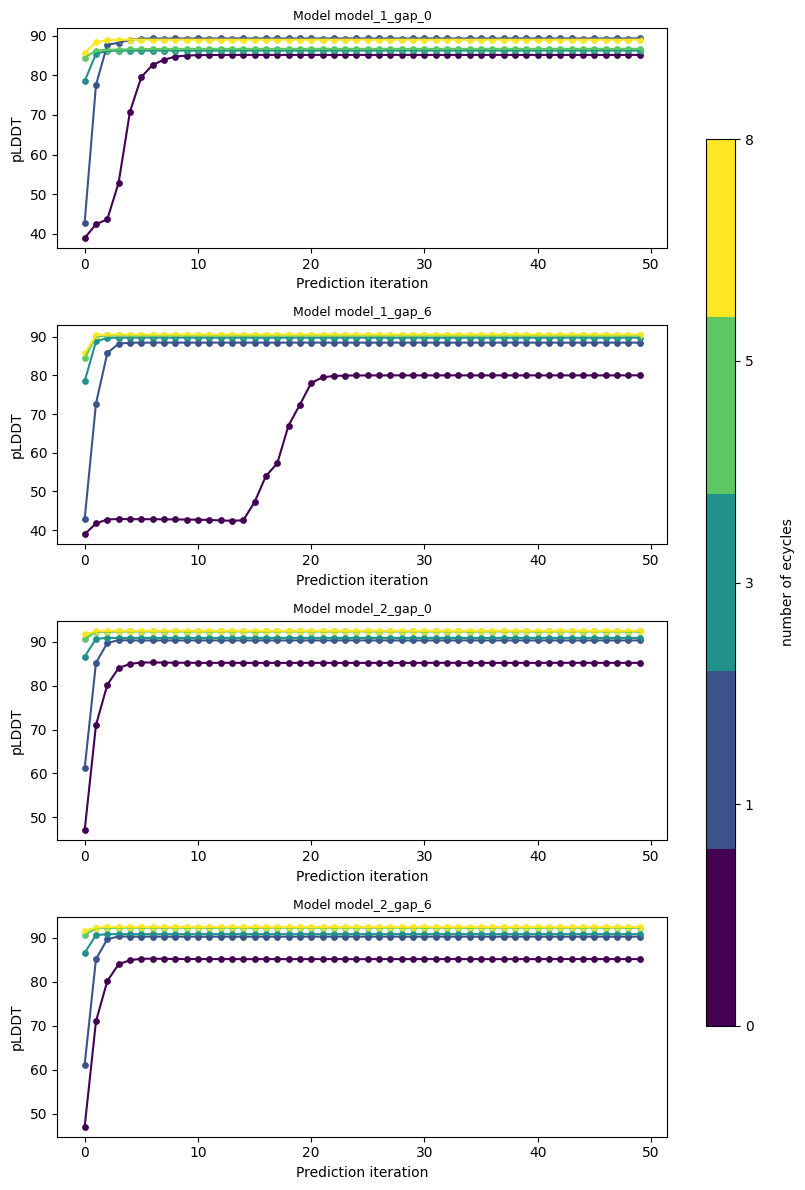

In [ ]:
#@title Visualize previously generated iterative structure predictions - check statistics of predictions for selected pdb {"vertical-output":true,"form-width":"50%","display-mode":"form"}
pdb_id = "2r4q" #@param {type:"string"}
pdb_id = pdb_id.lower()
sub_traj_record_ids = {'zenodo_id_subtrajs.json':'13857269'}

from concurrent.futures import ThreadPoolExecutor, as_completed

!pip install mdtraj
import glob
import mdtraj as md
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Function to extract pLDDT values from a PDB file
def get_plddt(pdb):
    n_res = md.load(pdb).n_residues
    run_residues = list(range(1, n_res+1))

    with open(pdb, 'r') as fh:
        atom_lines = []
        for line in fh.readlines():
            # atom_count = 0
            if re.search(r'^ATOM', line):
              # atom_lines.append(line)
              # atom_count += 1
                if int(line[22:26]) in run_residues:
                    # atom_count += 1
                    atom_lines.append(line)
                    run_residues = run_residues[1:]
        str_bfactors1 = [l[61:65] for l in atom_lines]
        flt_bfactors1 = np.array([float(i)/100 for i in str_bfactors1]).astype("float32")

    return flt_bfactors1

# Function to run get_plddt concurrently for multiple PDB files
def process_plddts_in_parallel(pdb_files, max_workers=4):
    plddts = {}

    # Use ThreadPoolExecutor for multi-threading
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit tasks to the executor
        futures = {executor.submit(get_plddt, pdb): pdb for pdb in pdb_files}

        # Collect the results as they are completed
        for future in as_completed(futures):
            pdb = futures[future]
            try:
                result = future.result()
                plddts[pdb] = result
            except Exception as e:
                print(f"Error processing {pdb}: {e}")
    return plddts

if pdb_id is not None:
    if pdb_id in fig_1_6_pdbs:
        download_file = f"{pdb_id.lower()}.zip"
        record_id = record_ids['18_and_embeddings']
        download_zenodo(record_id,download_file=download_file)
        download_file = os.path.join('zenodo_downloads', download_file)
        extract_zip_multithreaded(download_file, 'zenodo_downloads', num_threads=4)
    else:
        download_zenodo('13857269',download_file='zenodo_id_subtrajs.json')
        sub_traj_zenodo_id_index = json.load(open('zenodo_downloads/zenodo_id_subtrajs.json'))
        sub_traj_zenodo_id_index_zip = {'1':['13841237','13836304'],'2':['13836288','13836290'],
                                        '3':['13836306','13836308'],'4':['13836319','13836313'],
                                        '5':['13836321'],'6':['13836295'],'7':['13841213'],'8':['13836304']}
        sub_traj_zenodo_id = sub_traj_zenodo_id_index_zip[pdb_id[0]]
        download_sub_traj_zenodo_id = []
        for id in sub_traj_zenodo_id:
            sub_traj_zips = sub_traj_zenodo_id_index[id].keys()
            for zip_key in sub_traj_zips:
                sub_trajs = sub_traj_zenodo_id_index[id][zip_key]
                for sub_traj in sub_trajs:
                    if sub_traj[-4:] == '.xtc' and pdb_id in sub_traj:
                        download_sub_traj_zenodo_id.append((id, zip_key, sub_traj))
        for (id, zip_key, sub_traj) in download_sub_traj_zenodo_id:
            if not os.path.exists(os.path.join('zenodo_downloads', sub_traj)):
              download_zenodo(id, download_file=zip_key)
              # sub_traj = os.path.join('zenodo_downloads', sub_traj)
            zip_key = os.path.join('zenodo_downloads', zip_key)
            extract_zip_multithreaded(zip_key, 'zenodo_downloads', file_name=[pdb_id], num_threads=4)
        extract_zip_multithreaded('zenodo_downloads/model_1_2_gap_0_6_per_residue_plddts.zip', 'zenodo_downloads', file_name=[pdb_id], num_threads=4)
        extract_zip_multithreaded('zenodo_downloads/0_0_iter_0_pdb.zip', 'zenodo_downloads', file_name=[pdb_id], num_threads=4)


# fig_1_6_trajs = {'3gb1':'run_2nd_nosamplemodel_model_1_gap0/2_0/','1mi0':'run_2nd_nosamplemodel_model_1_gap0/1_0/',
#                  '1hz5':'run_2nd_nosamplemodel_model_1_gap0/0_0/','1kh0':'run_2nd_nosamplemodel_model_2_gap0/0_0/',
#                  '1ubq':'run_2nd_nosamplemodel_model_1_gap0/2_0/','2hda':'run_2nd_nosamplemodel_model_1_gap0/2_0/',
#                  '1fnf':'run_2nd_nosamplemodel_model_2_gap0/1_0/'}
fig_1_6_trajs = {'3gb1':'run_2nd_nosamplemodel_model_1_gap0','1mi0':'run_2nd_nosamplemodel_model_1_gap0',
                 '1hz5':'run_2nd_nosamplemodel_model_1_gap0','1kh0':'run_2nd_nosamplemodel_model_2_gap0',
                 '1ubq':'run_2nd_nosamplemodel_model_1_gap0','2hda':'run_2nd_nosamplemodel_model_1_gap0',
                 '1fnf':'run_2nd_nosamplemodel_model_2_gap0'}

models = ['run_2nd_nosamplemodel_model_1_gap0','run_2nd_nosamplemodel_model_1_gap6','run_2nd_nosamplemodel_model_2_gap0','run_2nd_nosamplemodel_model_2_gap0']
if pdb_id in fig_1_6_pdbs:
  pdbs = [glob.glob(f"zenodo_downloads/{pdb_id}/{fig_1_6_trajs[pdb_id]}/{recycle}_*/iter_{step}.pdb")[0] for recycle in range(11) for step in range(50)]
  plddts = process_plddts_in_parallel(pdbs)
  plddts = [plddts[pdb] for pdb in pdbs]
  traj_all = md.load(pdbs)
else:
  traj = [glob.glob(f"zenodo_downloads/*/{pdb_id}/{model}/*xtc")[0] for model in models]

  top = glob.glob(f"zenodo_downloads/*/{pdb_id}/{pdb_id}*pdb")[0]
  total_frames = 2500
  all_frames = list(range(total_frames))
  traj_list = [x for i in range(0, total_frames, 500) for x in all_frames[i:i+100]]
  traj_all = md.load(traj[0],top=top)[traj_list]
  for i in range(1,4):
    traj_all += md.load(traj[i],top=top)[traj_list]
  plddts = []
  for model in models:
    plddts_json = glob.glob(f"zenodo_downloads/*seq*/{pdb_id}/{model}/*plddt*json")[0]
    plddts_json = json.load(open(plddts_json))
    plddts.append([plddts_json[f'{recycle}_0/iter_{step}.pdb'] for recycle in [0,1,3,5,8] for step in range(100)])
  plddts = np.concatenate(plddts)/100

CA_atoms=traj_all.top.select(f"name CA")
traj_all=traj_all.atom_slice(CA_atoms)
xyz = [traj_all.xyz[i]*10 for i in range(len(traj_all))]
seq = [sequence_to_one_hot(traj_all.top.to_fasta()[0])[None,:,:]]*len(xyz)
if pdb_id in fig_1_6_pdbs:
  #recycling plot
  first_max_hit = []
  colors = plt.cm.plasma_r(np.linspace(0, 1, 12))[-11:]
  fig,ax = plt.subplots(1,1,figsize=(10,2))
  plot_steps = 20
  plddts = np.array(plddts).reshape(11,50,len(plddts[-1]))
  average_plddts = np.average(plddts, axis=2)
  for i in range(11):
    tmp_max_hit = []
    tmp_plddts = average_plddts[i]
    ax.plot(tmp_plddts[:plot_steps]*100,label=str(i),color=colors[i])
    ax.scatter(list(range(plot_steps)),tmp_plddts[:plot_steps]*100,s=20,color=colors[i])
  ax.set_yticks(list(range(60,100,10)))
  ax.set_ylabel("average pLDDT")
  ax.set_xticks(list(range(0,plot_steps)))
  ax.set_xlabel("Prediction iteration")
  fig.set_title("pLDDT of iterative structure predictions with increasing number of recycles (0-10)")
  plt.legend()
  plt.show()
else:
  #plot plddts for four models
  fig,ax=plt.subplots(4,1,figsize=(8.4,12))
  average_plddts = plddts.mean(axis=1)

  num_recycles = 5
  recycles = [0,1,3,5,8]
  cmap = cm.get_cmap('viridis', num_recycles)
  norm = mcolors.Normalize(vmin=0, vmax=num_recycles-1)
  models = ['model_1_gap_0','model_1_gap_6','model_2_gap_0','model_2_gap_6']
  plot_steps = 50
  # Plot the data using the colormap
  for model in range(4):
      for recycle in range(5):
          color = cmap(recycle)  # Get the color from the colormap
          start_step = model*500+recycle*100
          tmp_plddts = average_plddts[start_step:start_step+plot_steps]*100
          ax[model].plot(tmp_plddts,
                        color=color,
                        label=f'recycle {recycle}')
          ax[model].scatter(list(range(len(tmp_plddts))),tmp_plddts,
                        color=color,
                        label=f'recycle {recycle}',s=15)

      ax[model].set_xlabel("Prediction iteration")
      ax[model].set_ylabel("pLDDT")
      ax[model].set_title(f"Model {models[model]}",fontsize=9)
  plt.tight_layout()
  # Add a colorbar to indicate recycle steps
  sm = cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])  # Needed to avoid a warning
  cbar = fig.colorbar(sm, ax=ax,shrink=0.8, aspect=30) #, orientation='vertical', pad=0.02)
  cbar.set_label('number of ecycles', rotation=90, labelpad=20)
  cbar.set_ticks([0, 1, 2, 3, 4])
  cbar.set_ticklabels(['0', '1', '3', '5', '8'])



In [ ]:
#@title Visualize previously generated iterative structure predictions - visualizing folding trajectory of selected pdb {"vertical-output":true,"form-width":"50%","display-mode":"form"}
models = ['model_1_gap_0','model_1_gap_6','model_2_gap_0','model_2_gap_6']

fig_1_6_trajs_index = {'3gb1':'2','1mi0':'1','1hz5':'0',
                       '1kh0':'0','1ubq':'2','2hda':'2','1fnf':'1'}
if pdb_id not in fig_1_6_pdbs:
  #@markdown - if pdb is one of the large scale predictions, select the number of recycles to visualize the trajectory here. We recommend selecting the model and recycle number for the trajectory folding into native with the least number of recycles.
  model = 'model_1_gap_0' #@param ['model_1_gap_0','model_1_gap_6','model_2_gap_0','model_2_gap_6']
  recycle = "0" #@param ['0','1','3','5','8']
  recycles = ['0','1','3','5','8']
else:
  #@markdown - if pdb is one of 3GB1, 1MI0, 1HZ5, 1KH0, 1UBQ, 2HDA, 1FNF, select the number of recycles to automatically visualize the trajectory here. Default is None to visualize the trajectory folding into native with the least number of recycles.
  recycle = None #@param ['None', '0','1','2','3','4','5','6','7','8','9','10']

if pdb_id in fig_1_6_pdbs:
  recycle_index = int(fig_1_6_trajs_index[pdb_id.lower()]) if recycle is None else int(recycle)
  start_index = recycle_index*50
  end_index = start_index+plot_steps
  sub_xyz = xyz[start_index:end_index]
  sub_plddts = plddts[recycle_index][:plot_steps]
  sub_seq = seq[start_index:end_index]
else:
  models_index = models.index(model)
  recycle_index = recycles.index(recycle)
  start_index = models_index*500+recycle_index*100
  end_index = start_index+plot_steps
  sub_xyz = xyz[start_index:end_index]
  sub_plddts = plddts[start_index:end_index]
  sub_seq = seq[start_index:end_index]
HTML(make_animation(sub_seq, xyz=sub_xyz, pae=None, plddt=sub_plddts, dpi=80, interval=300))
